# TP CLUSTERING DANS UN BUT DE SEGMENTATION

# Sommaire

1. [Import](#sect1)
2. [Réduction de dimension via une ACP](#sect2)
3. [Clustering Mixte](#sect3)
4. [Portraits Robots](#sect4)


In [44]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
os.chdir("../data")

# 1. Import <a name="sect1"></a> 

## LES DONNEES
Housing data lien : https://www.kaggle.com/apratim87/housingdata/version/1#housingdata.csv


Variables dans l'ordre : 

- **CRIM** per capita crime rate by town 
- **ZN** proportion of residential land zoned for lots over 25,000 sq.ft. 
- **INDUS** proportion of non-retail business acres per town 
- **CHAS** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
- **NOX** nitric oxides concentration (parts per 10 million) 
- **RM** average number of rooms per dwelling 
- **AGE** proportion of owner-occupied units built prior to 1940 
- **DIS** weighted distances to five Boston employment centres 
- **RAD** index of accessibility to radial highways 
- **TAX** full-value property-tax rate per $10,000 
- **PTRATIO** pupil-teacher ratio by town 
- **LSTAT** ratio de lower status of the population 
- **MEDV** Median value of owner-occupied homes en milliers de dollars


In [45]:
housing = pd.read_csv('housingdata.csv',header=0,index_col=False,sep=',',
names=["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","MEDV"])

In [46]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
1,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
3,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7
4,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,12.43,22.9


In [47]:
housing.shape

(504, 13)

In [48]:
housing.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX          int64
PTRATIO    float64
LSTAT      float64
MEDV       float64
dtype: object

#### Transformation des données au bon format et regroupement par classe

In [49]:
housing['CHAS']=housing['CHAS'].astype(bool)

In [50]:
stats = housing.describe(include="all")
stats

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
count,504.000000,504.000000,504.000000,504,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.627796,11.373016,11.162361,NaN,0.554898,6.283788,68.561111,3.792132,9.581349,408.789683,18.463095,12.675258,22.531746
std,8.615632,23.361404,6.860259,NaN,0.116042,0.703867,28.200606,2.109202,8.709660,168.633955,2.164467,7.145309,9.215044
min,0.009060,0.000000,0.460000,NaN,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,NaN,0.449000,5.884750,44.850000,2.097050,4.000000,279.000000,17.400000,6.990000,16.950000
50%,0.260420,0.000000,9.690000,NaN,0.538000,6.205000,77.500000,3.190950,5.000000,330.000000,19.100000,11.395000,21.200000
75%,3.681942,12.500000,18.100000,NaN,0.624000,6.626000,94.100000,5.212575,24.000000,666.000000,20.200000,16.992500,25.000000


In [51]:
# Créer 3 groupes de valeur des logements <15 , 15-25 et 25+ pour constituer une variable de contrôle à la fin de la segmentation
housing["Valeur_Immo"] = '2.15k-25k$'
housing.loc[housing['MEDV'] >= 25, 'Valeur_Immo'] = '3.>25k$'
housing.loc[housing['MEDV'] <15, 'Valeur_Immo'] = '1.<15k$'
housing['Valeur_Immo']=housing['Valeur_Immo'].astype('category')
housing['Valeur_Immo'].describe()

count            504
unique             3
top       2.15k-25k$
freq             278
Name: Valeur_Immo, dtype: object

# 2. REDUCTION DE DIMENSIONS AVEC ACP <a name="sect2" ></a>

In [52]:
# ACP sur les var numérique et doit être appliquée sur des données standardisées
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# MEDV ne sont plus des variables qu'on veut projetter et Valeur Immo sera une variable de controle du clustering
X = housing.drop(["MEDV","Valeur_Immo"],axis=1)
# on écrase et on standardise
X = StandardScaler().fit_transform(X)

In [53]:
# CALCUL ACP AVEC SKLEARN avec autant de composants que de colonnes avant de filtrer le nombre de composants (=dimensions)
pca_housing = PCA(n_components=X.shape[1]).fit(X)
CP_housing = pca_housing.transform(X)
# projection des 505 villes sur les nouvelles dimensions

In [54]:
# Analyse des différences de projection
X[0]

array([-0.41831909, -0.48731297, -0.5971243 , -0.27317918, -0.74096695,
        1.2816455 , -0.26483559,  0.55762106, -0.87131776, -0.99004613,
       -0.30665935, -1.21112288])

In [55]:
CP_housing[0]

array([-2.03568405,  0.63823533,  0.01575284, -0.97093418,  0.80703978,
        0.51227253, -0.10581473,  0.05350127,  0.1865577 ,  0.48972618,
        0.14032252, -0.01354096])

In [56]:
print(pca_housing.explained_variance_ratio_) # 3 composantes expliquent 75% de la variance des données

[0.49223103 0.11668486 0.09842775 0.07111062 0.06695671 0.04467627
 0.03303232 0.02320461 0.01872156 0.0154672  0.01420034 0.00528675]


In [57]:
print(np.cumsum(np.round(pca_housing.explained_variance_ratio_, decimals=4)*100))

[ 49.22  60.89  70.73  77.84  84.54  89.01  92.31  94.63  96.5   98.05
  99.47 100.  ]


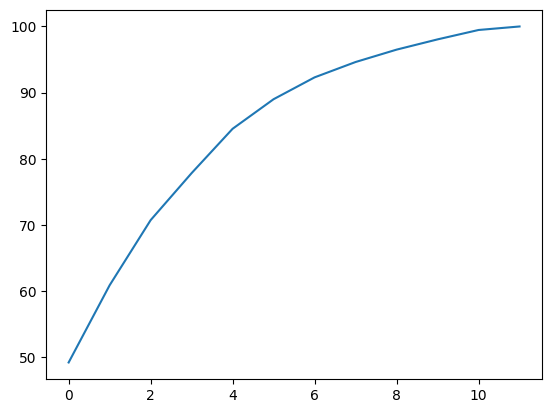

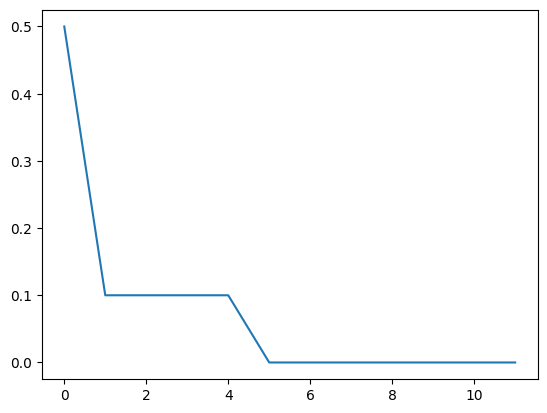

In [58]:
plt.plot(np.cumsum(np.round(pca_housing.explained_variance_ratio_, decimals=4)*100))
plt.figure()
plt.plot(np.round(pca_housing.explained_variance_ratio_, decimals=1))


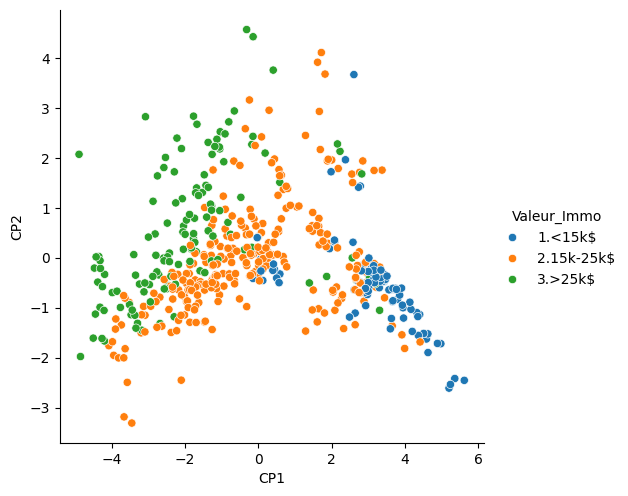

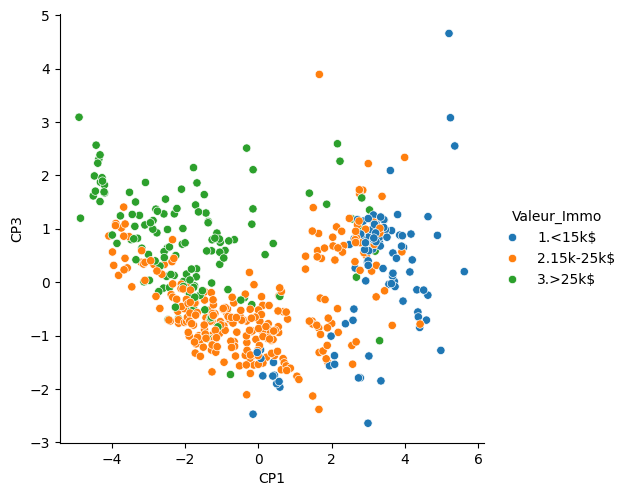

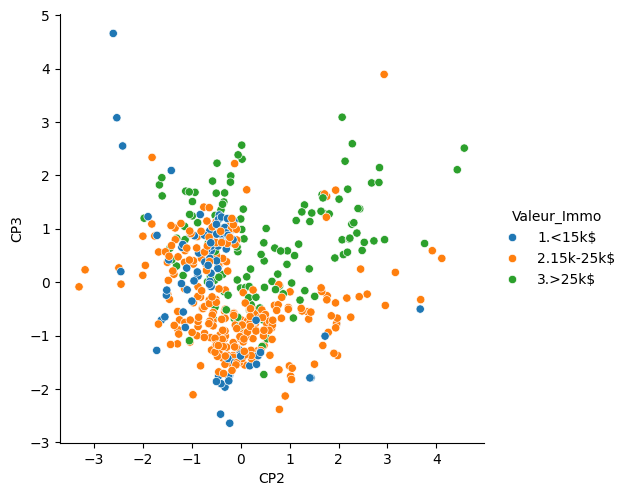

In [59]:
import seaborn as sns
targets = housing.Valeur_Immo.unique()

# Conservation d'uniquement 3 axes et rapprochement avec les données de Valur Immobilière
finalDf = pd.concat([pd.DataFrame(CP_housing[:,0:3], columns = ['CP1', 'CP2','CP3']), housing[["CHAS","MEDV",'Valeur_Immo']]], axis = 1)
sns.pairplot(x_vars='CP1', y_vars='CP2', data=finalDf, hue="Valeur_Immo", height=5)
sns.pairplot(x_vars='CP1', y_vars='CP3', data=finalDf, hue="Valeur_Immo", height=5)
sns.pairplot(x_vars='CP2', y_vars='CP3', data=finalDf, hue="Valeur_Immo", height=5)
# Les 3 catégories de valeur immobilière sont assez corrélées avec l'axe 1 et 3

#### INTERPRETATION DES AXES


La règle des 70% de la variance expliquée nous fait sélectionner uniquement 3 axes

<Axes: >

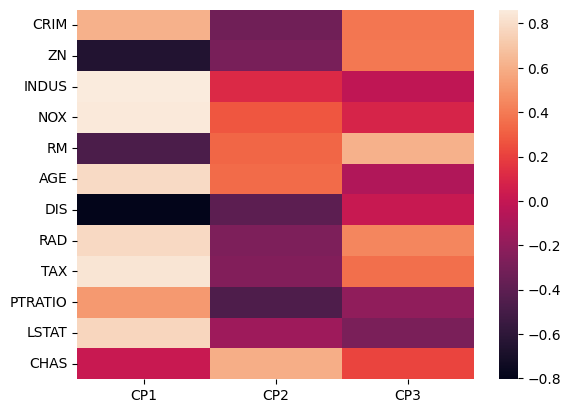

In [60]:
import matplotlib.pyplot as plt
analyse = pd.concat([pd.DataFrame(CP_housing[:,0:3], columns = ['CP1', 'CP2','CP3']), housing[["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT", "CHAS"]]], axis = 1)
corr=analyse.corr().loc[["CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","CHAS"],["CP1","CP2","CP3"]]
plt.figure()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.index.values)

In [61]:
corr

,CP1,CP2,CP3
CRIM,0.610326,-0.323622,0.382666
ZN,-0.648442,-0.293898,0.389227
INDUS,0.862326,0.111760,-0.016735
NOX,0.850849,0.274908,0.084224
RM,-0.477001,0.323668,0.610562
AGE,0.786673,0.344865,-0.081193
DIS,-0.804475,-0.404598,0.015122
RAD,0.782701,-0.272489,0.444161
TAX,0.831620,-0.251609,0.360357
PTRATIO,0.511486,-0.464991,-0.199124


In [62]:
housing.groupby(['Valeur_Immo']).mean().T

C:\Users\wilverde\AppData\Local\Temp\ipykernel_36956\2073602907.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  housing.groupby(['Valeur_Immo']).mean().T


Valeur_Immo,1.<15k$,2.15k-25k$,3.>25k$
CRIM,12.909406,1.805271,0.856514
ZN,0.000000,8.937050,24.602273
INDUS,17.509362,11.235504,6.488485
CHAS,0.010638,0.064748,0.121212
NOX,0.673489,0.543499,0.494454
RM,5.859096,6.082856,7.009394
AGE,93.761702,66.356835,55.257576
DIS,2.074044,4.100754,4.365642
RAD,19.117021,7.960432,6.204545
TAX,600.542553,388.007194,316.007576


# 3. CLUSTERING MIXTE <a name="sect3" ></a>

La classification mixte permet de garder les qualités des méthodes de nuées dynamiques 
et de la classification hiérarchique en contournant leurs inconvénients.
On commence par une k-means pour diminuer la dimension du problème 
puis on fait une classification hiérarchique sur les centroides.

In [63]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy import cluster
from sklearn.cluster import AgglomerativeClustering

In [64]:
# On fait une k-means avec beaucoup de clusters et on récupère les coordonnées des centroides
# une bonne pratique est de choisir n^(1/3) -> limite de wong
k_means_cent = KMeans(n_clusters = round(len(X)**(1/3)), random_state = 2016).fit(CP_housing[:,0:3])
# barycentres des  classes issues de la partition KM
centroides = k_means_cent.cluster_centers_

In [65]:
print(centroides)

[[ 2.80521309 -0.34101966  0.91785888]
 [-2.01031181  0.70862373  0.46230286]
 [ 1.95344063  1.01512482 -1.19306789]
 [-3.62881383 -1.0488256   1.02438958]
 [-0.06188446  0.2934567  -1.04745907]
 [-0.56002704  2.69337054  0.93191112]
 [-1.66992932 -0.49205857 -0.68583572]
 [ 4.19441042 -1.29897011  0.39844868]]


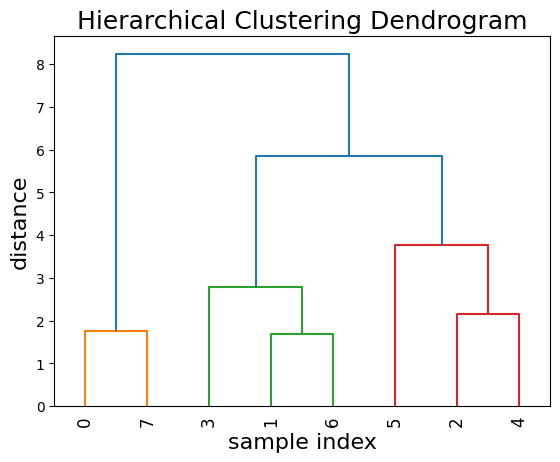

In [66]:
# 22 individus fictifs (barycentres)

# On trace le dendogramme 
# étape préliminaire avec la cluster.hierarchy (CAH): bénéfice de pouvoir représenter
Z = cluster.hierarchy.linkage(centroides, method='ward', metric='euclidean')
plt.figure()

plt.title('Hierarchical Clustering Dendrogram', fontsize=18)

plt.xlabel('sample index', fontsize=16)

plt.ylabel('distance', fontsize=16)
dn = cluster.hierarchy.dendrogram(Z, leaf_font_size=12, leaf_rotation=90.)


In [67]:
# etape partitionner par rapport au nombre = 3 ou 4
# On peut ensuite réaliser le clustering à l'aide de scikit-learn
hac_cent = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
hac_cent.fit(centroides)

,n_clusters,3
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'ward'
,distance_threshold,None
,compute_distances,False


In [68]:
# On récupère le cluster assigné lors du K-means puis lors du CAH pour avoir un cluster final pour chaque observation
kmeans_cent_df = pd.DataFrame(k_means_cent.labels_, columns = ['K-means_cent']).reset_index()
kmeans_cent_df

,index,K-means_cent
0,0,1
1,1,1
2,2,1
3,3,6
4,4,6
...,...,...
499,499,4
500,500,4
501,501,4
502,502,4


In [69]:
kmeans_cent_df['K-means_cent'].value_counts()

K-means_cent
4    98
6    95
0    94
3    61
1    46
2    40
7    37
5    33
Name: count, dtype: int64

In [70]:
hac_cent_df = pd.DataFrame(hac_cent.labels_, columns = ['Typologie']).reset_index()
hac_cent_df.sort_values(['Typologie'])

,index,Typologie
2,2,0
4,4,0
5,5,0
0,0,1
7,7,1
1,1,2
3,3,2
6,6,2


In [71]:
cluster_cent = pd.merge(kmeans_cent_df, hac_cent_df, left_on=['K-means_cent'], right_on=['index'], how='left')
cluster_cent = cluster_cent.drop(['K-means_cent','index_y'], axis =1)

In [72]:
print(cluster_cent['Typologie'].value_counts())
print(cluster_cent['Typologie'].value_counts(normalize=True))


Typologie
2    202
0    171
1    131
Name: count, dtype: int64
Typologie
2    0.400794
0    0.339286
1    0.259921
Name: proportion, dtype: float64


In [73]:
# Jointure finale avec tous les 
typologie = pd.merge(left=housing, right=cluster_cent, how='inner',left_index=True, right_index=True)

# 4. Portraits Robots <a name="sect4" ></a> 

In [74]:
#Pour chaque cluster, on calcule la moyenne des variables quantitatives
# et la proportion des variables qualitatives. On peut ainsi voir en quels domaines les clusters se différencient. Ci-dessous le portrait robot de la classification mixte :

# Variables quanti : moyenne de la variable
# le index =false permet que le resultat reprenne bien les var en group by
stats=typologie.groupby(['Typologie'])[["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","MEDV"]].mean()
stats.T

Typologie,0,1,2
CRIM,0.734873,12.830169,0.108880
ZN,1.903509,0.000000,26.764851
INDUS,12.876725,18.100000,5.211931
CHAS,0.134503,0.053435,0.024752
NOX,0.588420,0.672069,0.450534
RM,6.172760,6.001099,6.561104
AGE,84.238012,89.858015,41.478713
DIS,2.834306,2.062449,5.724690
RAD,4.725146,24.000000,4.341584
TAX,351.017544,666.000000,290.891089


In [75]:
pd.crosstab(typologie['Typologie'], typologie['Valeur_Immo'], normalize='columns')

Valeur_Immo,1.<15k$,2.15k-25k$,3.>25k$
Typologie,,,
0,0.244681,0.424460,0.227273
1,0.755319,0.176259,0.083333
2,0.000000,0.399281,0.689394


#### UTILISER UNE FONCTION DE PORTRAITS ROBOTS

cette fonction permet de calculer les P-values du t-test

In [76]:
os.chdir("../modules/")
from portraits_robots_quanti import portraits_robot_quanti
from pouvoir_discriminant import pouvoir_discriminant

In [77]:
stats=portraits_robot_quanti(typologie, 'Typologie', ["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","MEDV"])
# Pour chaque variable on a la moyenne de la variable par classe de la typologie et la pvalue associée
stats.sort_values('index')

c:\Users\wilverde\Workspace\form_python_ML\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,index,VARIABLE,p-value_0,p-value_1,p-value_2,y_0,y_1,y_2,y_All
3,0.0,CRIM,0.0,0.0,0.0,0.734873,12.830169,0.108880,3.627796
13,1.0,ZN,0.0,0.0,0.0,1.903509,0.000000,26.764851,11.373016
5,2.0,INDUS,0.000052,0.0,0.0,12.876725,18.100000,5.211931,11.162361
2,3.0,CHAS,0.000034,0.403106,0.001209,0.134503,0.053435,0.024752,0.069444
8,4.0,NOX,0.000003,0.0,0.0,0.588420,0.672069,0.450534,0.554898
11,5.0,RM,0.011021,0.0,0.0,6.172760,6.001099,6.561104,6.283788
1,6.0,AGE,0.0,0.0,0.0,84.238012,89.858015,41.478713,68.561111
4,7.0,DIS,0.0,0.0,0.0,2.834306,2.062449,5.724690,3.792132
10,8.0,RAD,0.0,0.0,0.0,4.725146,24.000000,4.341584,9.581349
12,9.0,TAX,0.0,0.0,0.0,351.017544,666.000000,290.891089,408.789683


In [78]:
# Fonction qui calcule pour chaque variable numérique si la typologie explique bien leur variance
# VB = Variance Between
# VW = Variance Within
# VT = Variance Totale
# Tx* = Taux des variances par rapport à la variance Totale
# Calinski = Statistique de Calinski-HaraBascz (Plus c'est élevée plus la variable joue en la faveur de la variance Between)

pouvoirDiscrimant=pouvoir_discriminant(typologie, 'Typologie', ["CHAS","CRIM","ZN","INDUS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT","MEDV"])
pouvoirDiscrimant

,Variable,VB,VW,VT,Calinski,TxVarWithin,TxVarBetween
8,RAD,3.681315e+04,1.343513e+03,3.815666e+04,6863.869271,3.52,96.48
9,TAX,1.204514e+07,2.258883e+06,1.430402e+07,1335.751766,15.79,84.21
6,AGE,2.496001e+05,1.504228e+05,4.000229e+05,415.660730,37.60,62.40
4,NOX,4.190825e+00,2.582488e+00,6.773313e+00,406.507765,38.13,61.87
3,INDUS,1.396006e+04,9.712708e+03,2.367276e+04,360.043157,41.03,58.97
7,DIS,1.303233e+03,9.344799e+02,2.237713e+03,349.349169,41.76,58.24
11,LSTAT,1.063443e+04,1.504645e+04,2.568089e+04,177.046731,58.59,41.41
1,CRIM,1.502598e+04,2.231127e+04,3.733725e+04,168.704335,59.76,40.24
2,ZN,8.013363e+04,1.943812e+05,2.745149e+05,103.268585,70.81,29.19
10,PTRATIO,5.547424e+02,1.801771e+03,2.356514e+03,77.125752,76.46,23.54


## Réaffection - ***Optionnel***


Dans cette section, il s’agit de proposer des techniques d’affectation à une segmentation pré-existante et dont nous possédons un échantillon : nous avons des observations sur des individus dont nous connaissons le segment. On est ici dans un cadre de classification supervisée.

On commence par séparer notre base en deux : une partie pour apprendre le lien entre les variables explicatives et la cible (la classe d’appartenance du client : ici la classification mixte), et une autre sur laquelle on évalue la qualité de la méthode d’affectation - principe de ne pas être juge et partie.

On choisit la taille respective des bases - ici 75% pour l’apprentissage - , puis on tire 75% des lignes au hasard que l’on affecte à la base train, le reste étant affecté à test.


In [79]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(typologie[["CRIM","ZN","INDUS","CHAS","NOX","RM","AGE","DIS","RAD","TAX", "PTRATIO","LSTAT"]],typologie['Typologie'],test_size = 0.25, random_state = 42)

In [80]:
# Plus proches voisins (Nouvelles méthodes par exemple)

# On cherche les plus proches voisins de chaque individu et on lui affecte la classe majoritaire parmi ses voisins. 
# Le paramètre de la méthode est le nombre K de voisins - ici K = 8.
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train,y_train)

,n_neighbors,8
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [81]:
y_pred_test = knn.predict(X_test)
y_pred_train = knn.predict(X_train)

In [82]:

#La qualité de la méthode se lit sur la matrice de confusion. Cette méthode est utilisée sur les variables quantitatives.
print(pd.crosstab(y_pred_test, y_test,normalize='index'))
print(pd.crosstab(y_pred_test, y_test,normalize='columns'))

Typologie         0         1         2
row_0                                  
0          0.767442  0.000000  0.232558
1          0.058824  0.941176  0.000000
2          0.061224  0.000000  0.938776
Typologie         0    1         2
row_0                             
0          0.868421  0.0  0.178571
1          0.052632  1.0  0.000000
2          0.078947  0.0  0.821429


In [83]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train,y_pred_train),accuracy_score(y_test,y_pred_test)

(0.9338624338624338, 0.8809523809523809)